In [1]:
import keras
import numpy as np
import cv2
import os
import sys
import glob
import shutil
from matplotlib import pyplot as plt

from model import *
from data import *

Using TensorFlow backend.


In [2]:
target_images = './data/sky/iphone_full/test_myown/*'
target_images = glob.glob(target_images)
target_images.sort()

NameError: name 'glob' is not defined

In [3]:
tmp_files = './data/sky/test'
shutil.rmtree(tmp_files, ignore_errors=True)

if not os.path.exists(tmp_files):
    os.mkdir(tmp_files)

In [4]:
model = unet_modify()
model.load_weights('models/Unet.104-0.99_b.hdf5')

/home/dmitrii/.virtenvs/FaceIidentification/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/dmitrii/sky_detect/Semantic-Segmentation-Suite/UNET/sky-segmentation/keras_unet/model.py:79: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


In [5]:
result_path = './data/sky/result'
shutil.rmtree(result_path, ignore_errors=True)

if not os.path.exists(result_path):
    os.mkdir(result_path)

[INFO]:: ./data/sky/iphone_full/test_myown/0.jpg was success processed.


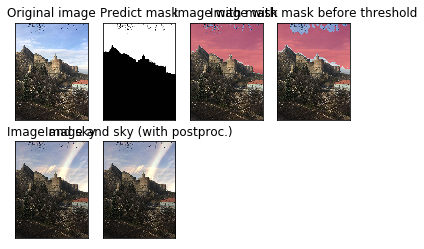

[INFO]:: ./data/sky/iphone_full/test_myown/1.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/10.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/11.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/12.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/13.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/14.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/15.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/16.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/17.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/18.jpg was success processed.


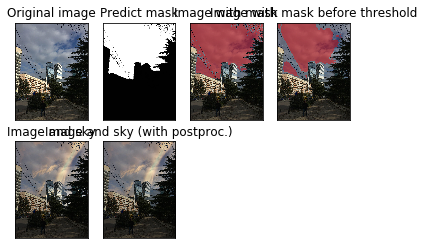

[INFO]:: ./data/sky/iphone_full/test_myown/19.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/2.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/20.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/21.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/22.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/23.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/24.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/25.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/3.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/4.jpg was success processed.


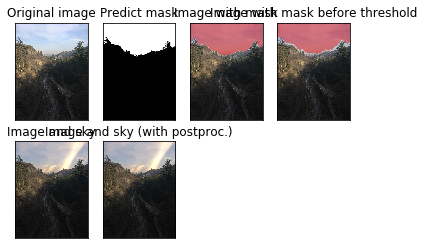

[INFO]:: ./data/sky/iphone_full/test_myown/5.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/6.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/7.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/8.jpg was success processed.
[INFO]:: ./data/sky/iphone_full/test_myown/9.jpg was success processed.
[INFO]:: Common count : 27


In [6]:
count = 0
for path in target_images:
    try:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, code=cv2.COLOR_BGR2RGB)
        img = image.copy()
        image = image / 255.
        image = cv2.resize(image, (256, 256))
        image = np.expand_dims(image, 0)

        raw_mask = model.predict(image)[0, :, :, 0]

        image = img
        s1, s2 = (image.shape[0], image.shape[1])

        raw_mask = cv2.normalize(raw_mask, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        # Otsu threshold
        ret,mask = cv2.threshold(raw_mask.copy(), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Contour detection
        _, contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contour by area
        contour_list = []
        area_threshold = 400

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > area_threshold :
                contour_list.append(contour)

        # Making binary mask by contour        
        countMask = np.zeros(mask.shape, dtype='uint8')
        cv2.drawContours(countMask, contour_list, -1, (255, 255, 255), cv2.FILLED)

        # Restore accuracy of border between sky and other objects
        mask = np.add(cv2.bitwise_not(mask), cv2.bitwise_not(countMask))
        mask = cv2.resize(cv2.bitwise_not(mask), (s2, s1))
        raw_mask = cv2.resize(raw_mask, (s2, s1))
        
        img_mask = image.copy()
        img_mask[cv2.bitwise_not(mask) == 0] = [255, 0, 0]
        
        img_mask_wt = image.copy()
        img_mask_wt[cv2.bitwise_not(raw_mask) == 0] = [255, 0, 0]

        result = cv2.addWeighted(image,0.5,img_mask,0.4,0.5)
        result_3 = cv2.addWeighted(image, 0.5, img_mask_wt, 0.4, 0.5)
        
        sky_image = cv2.imread('./data/sky/sky_3.jpg')
        sky_image = cv2.cvtColor(sky_image, code=cv2.COLOR_BGR2RGB)
        sky_image = cv2.resize(sky_image, (s2, s1))
        
#         test_mask = cv2.bitwise_not(mask)
#         print(np.unique(raw_mask))s
        test_mask = mask.copy()
        test_mask = test_mask / 255.
        test_mask[test_mask > 0.5] = 1
        test_mask[test_mask <= 0.5] = 0
        
        test_mask = test_mask.astype(np.uint8)
        test_mask = np.expand_dims(test_mask, axis=2)
        test_mask = np.concatenate([test_mask, test_mask, test_mask], axis=-1)
                
        raw_mask = raw_mask / 255.
        raw_mask[raw_mask > 0.5] = 1
        raw_mask[raw_mask <= 0.5] = 0
        raw_mask = raw_mask.astype(np.uint8)
        raw_mask = np.expand_dims(raw_mask, 2)
        
        sky_mask = sky_image * raw_mask
        result_1 = cv2.addWeighted(image,0.7,sky_mask,0.5,0.3)
        
        sky_mask = sky_image * test_mask
        result_2 = cv2.addWeighted(image,0.7,sky_mask,0.5,0.3)
        
        io.imsave(os.path.join(result_path, '%d_mask.jpg'%count),result)
        io.imsave(os.path.join(result_path, '%d_sky.jpg'%count),result_1)
        io.imsave(os.path.join(result_path, '%d_sky_after_postproc.jpg'%count),result_2)
        io.imsave(os.path.join(result_path, '%d_mask_without_threshold.jpg'%count),result_3)
        io.imsave(os.path.join(result_path, '%d.jpg'%count),image)
        
        print('[INFO]:: {} was success processed.'.format(path))
        
        if (count % 10) == 0:
            titles = ['Original image','Predict mask','Image with mask', 'Image with mask before threshold', 'Image and sky', 'Image and sky (with postproc.)']
            imges = [image, mask, result, result_3, result_1, result_2]
            
            for i in range(6):
                plt.subplot(2,4,i+1),plt.imshow(imges[i],'gray')
                plt.title(titles[i])
                plt.xticks([]),plt.yticks([])

            plt.show()
        
        count += 1
        
    except Exception as e:
        print('[WARNING:: Trouble with {}]'.format(path))
        print(e)
        
print('[INFO]:: Common count : {}'.format(count + 1))